# Data Science Capstone Project

Student name: **Cynthia Pedrasa**  
Student pace: **self paced**  
Scheduled project review date/time:  **July 27, 2020 10:00-11:00am**  
Instructor name: **Jeff Herman**  
Blog post URL:https://cpedrasa.github.io/predicting_30-day_all_cause_readmission_from_hospital_discharge_summary

## Table of contents

Introduction: Data Science Framework  

**Part II**
  
II. <a href="#2.-Preprocess-Text-Data">Preprocess Text Data</a>  
  + A. <a href="#2a.-Train-Test-Split">Train Test Split</a>  
  + B. <a href="#2b.-Text-Preprocessing">Text Preprocessing</a>  


III. <a href="#3.-Text-Processing">Text Processing</a>  
  + A. <a href="#3a.-Tokenization-and-Cleaning">Tokenization and Cleaning</a>  
  + B. <a href="#3b.-CountVectorizer">CountVectorizer</a>   
 
IV.  <a href="#4.-Select-an-Algorithm">Select an Algorithm</a>  
V.   <a href="#5.-Build-the-Model">Build the Model</a>   
VI.  <a href="#6.-Model-Performance">Model Performance</a>   
VII.  <a href="#7.-Make-Predictions">Make Predictions</a>   


# 1a. Import the Libraries 

In [1]:
import pandas as pd
from pandas import set_option

import numpy as np
from numpy import mean , std, array
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt # plotting library for Python
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

import sqlite3  
from pandas import read_sql_query
import pyodbc
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

import os
from os import path
import sys
from glob import glob

import time
from IPython import display
import warnings
warnings.filterwarnings('ignore')
import pickle
import scipy as sp

from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score,  GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_predict 
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.datasets import make_classification
from collections import Counter

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, roc_curve, auc
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

import string
import re
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard
from keras.utils import np_utils
from keras.utils import to_categorical
import sklearn.metrics as metrics




Using TensorFlow backend.


## Define the Functions

In [2]:

## Performance Metrics
def calc_accuracy(y_actual, y_pred, thresh):
    # this function calculates the accuracy with probability threshold at thresh
    return (sum((y_pred > thresh) & (y_actual == 1))+sum((y_pred < thresh) & (y_actual == 0))) /len(y_actual)

def calc_recall(y_actual, y_pred, thresh):
    # calculates the recall
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_actual)

def calc_precision(y_actual, y_pred, thresh):
    # calculates the precision
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_pred > thresh)

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)


#Calculate and print scores        
def print_scores(y_test, y_pred):
    from sklearn.metrics import accuracy_score 
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import mean_squared_error  
    from sklearn.metrics import r2_score
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import auc
    from sklearn.metrics import classification_report
    from sklearn.metrics import roc_curve
    from sklearn.metrics import precision_score       
    print("Accuracy: {}".format((accuracy_score(y_test, y_pred).round(decimals=4)*100)),'%')
    print("Precision: {}".format(precision_score(y_test, y_pred)))
    print("Recall: {}".format(recall_score(y_test, y_pred)))
    print("F1-score: {}".format(f1_score(y_test, y_pred)))
    print("R2: {}".format(r2_score(y_test, y_pred)))
    print("MSE: {}".format(mean_squared_error(y_test, y_pred)))
    print("Prevalence: {}".format(calc_prevalence(y_pred)))
    print("Specificity: {}".format(calc_specificity(y_test, y_pred, 0.5)))
    print('---------------------------------------------------------------------')
    print('\n','Classification Report:')
    print(classification_report(y_test, y_pred, target_names = ['NO', 'YES']))
    print('---------------------------------------------------------------------')
    # Confusion matrix plot   
    from sklearn.metrics import confusion_matrix
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print('Confusion matrix:\n', conf_mat)
    labels = ['Class 0', 'Class 1']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()

#plot ROC curve
def plot_roc_curve(y_test, model_probs, lblname):
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import auc
    from sklearn.metrics import f1_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import precision_score
    auc = roc_auc_score(y_test, model_probs) 
    fpr, tpr, _ = roc_curve(y_test, model_probs)
    print('ROC AUC: %.3f' % roc_auc_score(y_test, model_probs).round(decimals=3))
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label = 'ROC AUC: %.3f' % roc_auc_score(y_test, model_probs).round(decimals=3))
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', alpha=.8)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xticks(np.arange(0,1.1,0.1))
    plt.yticks(np.arange(0,1.1,0.1))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show();
    
# plot the Precision-Recall Curve
def plot_pr_curve(y_test, y_pred, model_probs, lblname):
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import auc
    from sklearn.metrics import f1_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import precision_score
    precision, recall, _ = precision_recall_curve(y_test, model_probs)
    f1, pr_auc = f1_score(y_test, y_pred), auc(recall, precision)
    print('f1=%.3f PR AUC=%.3f' % (f1, pr_auc))
    # calculate the no skill line as the proportion of the positive class
    no_skill = len(y[y==1]) / len(y)
    # plot the no skill precision-recall curve
    plt.plot([0, 1], [no_skill, no_skill],color='red', linestyle='--', label='Random') 
    precision, recall, _ = precision_recall_curve(y_test, model_probs)
    plt.plot(recall, precision, marker='.', label=  'PR AUC: %.3f' % auc(recall, precision).round(decimals=3))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
      # show the legend
    plt.legend()
      # show the plot
    plt.show()

    
def exec_time():                        # record execution time
    execution_time = time.time() - start
    print('Execution time', time.strftime("%H:%M:%S", time.gmtime(execution_time)))
    


[<a href="#Data-Science-Capstone-Project">Jump back to Table of Contents</a>]  

# 1b. Load the Preprocessed data 

In [3]:
#Load the pre-processed data

df_adm_dcnotes = pd.read_csv('final_data.csv', parse_dates=['ADMITTIME', 'DISCHTIME','NEXT_ADM_DATE','DEATHTIME'])
df_adm_dcnotes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45321 entries, 0 to 45320
Data columns (total 10 columns):
SUBJECT_ID         45321 non-null int64
HADM_ID            45321 non-null int64
ADMITTIME          45321 non-null datetime64[ns]
DISCHTIME          45321 non-null datetime64[ns]
DAYS_NEXT_ADMIT    11128 non-null float64
NEXT_ADM_DATE      11128 non-null datetime64[ns]
ADMISSION_TYPE     45321 non-null object
DEATHTIME          0 non-null datetime64[ns]
TEXT               43880 non-null object
READMITTED         45321 non-null int64
dtypes: datetime64[ns](4), float64(1), int64(3), object(2)
memory usage: 3.5+ MB


[<a href="#Data-Science-Capstone-Project">Jump back to Table of Contents</a>]  

# 2. Preprocess Text Data  

# 2a. Train Test Split 

In [4]:
# shuffle the samples
df_adm_dcnotes = df_adm_dcnotes.sample(n = len(df_adm_dcnotes), random_state = 42)
df_adm_dcnotes = df_adm_dcnotes.reset_index(drop = True)

# Save 30% of the data as validation and test data 
df_valid_test=df_adm_dcnotes.sample(frac=0.30,random_state=42)

df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)

# use the rest of the data as training data
df_train=df_adm_dcnotes.drop(df_valid_test.index)

print('Test prevalence(n = %d):'%len(df_test),df_test.READMITTED.sum()/ len(df_test))
print('Valid prevalence(n = %d):'%len(df_valid),df_valid.READMITTED.sum()/ len(df_valid))
print('Train all prevalence(n = %d):'%len(df_train), df_train.READMITTED.sum()/ len(df_train))
print('all samples (n = %d)'%len(df_adm_dcnotes))

print('Relative frequencies of the class (train)')
print(df_test.READMITTED.value_counts(normalize=True))
print(df_test.READMITTED.value_counts())
print('Relative frequencies of the class (test)')
print(df_valid.READMITTED.value_counts(normalize=True))
print(df_valid.READMITTED.value_counts())
print('Relative frequencies of the class (test)')
print(df_train.READMITTED.value_counts(normalize=True))
print(df_train.READMITTED.value_counts())


Test prevalence(n = 6798): 0.05898793762871433
Valid prevalence(n = 6798): 0.06443071491615181
Train all prevalence(n = 31725): 0.06695035460992908
all samples (n = 45321)
Relative frequencies of the class (train)
0    0.941012
1    0.058988
Name: READMITTED, dtype: float64
0    6397
1     401
Name: READMITTED, dtype: int64
Relative frequencies of the class (test)
0    0.935569
1    0.064431
Name: READMITTED, dtype: float64
0    6360
1     438
Name: READMITTED, dtype: int64
Relative frequencies of the class (test)
0    0.93305
1    0.06695
Name: READMITTED, dtype: float64
0    29601
1     2124
Name: READMITTED, dtype: int64


#### Just like the Module 5 hospital readmission project, we are dealing with class imbalance. The readmitted target variable is the minority class and we will use sampling strategies, to prevent the model from always predicting the majority class (no readmission).
 

In [5]:
# split the training data into positive and negative
rows_pos = df_train.READMITTED == 1
df_train_pos = df_train.loc[rows_pos]
df_train_neg = df_train.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train prevalence (n = %d):'%len(df_train), df_train.READMITTED.sum()/ len(df_train))

Train prevalence (n = 4248): 0.5


[<a href="#Data-Science-Capstone-Project">Jump back to Table of Contents</a>]  

# 2b. Text Preprocessing  

Let's scrub our notes data before we tokenize.  Text preprocessing involves text cleaning and extraction.  In the cell below, write a function that allows us to remove lines that have ' '. For the lines that remain, make every word lowercase, remove newline characters \n, and any of the following punctuation marks: ",.'?!" 



In [6]:
def preprocess_text(df):
    # This function preprocesses the text by filling not a number and replacing new lines ('\n') and carriage returns ('\r')
    df.TEXT = df.TEXT.fillna(' ')                       # remove lines that have ' '
    df.TEXT = df.TEXT.str.replace('\n',' ')             # remove newline characters \n
    df.TEXT = df.TEXT.str.replace('\r',' ')             # remove carriage returns
    return df

In [7]:

# run the above pre-processing function on the train, validation, and test sets
df_train = preprocess_text(df_train)
df_valid = preprocess_text(df_valid)
df_test = preprocess_text(df_test)

In [8]:
#Let's check one of the discharge summaries
df_train.TEXT.iloc[0]

"Admission Date:  [**2166-5-30**]       Discharge Date:  [**2166-6-6**]  Date of Birth:   [**2117-1-14**]       Sex:  M  Service:  [**Location (un) 259**] [**Hospital1 **]  HISTORY OF PRESENT ILLNESS:  This is a 49-year-old gentleman with hepatitis B, alcohol-induced cirrhosis with multiple admissions for melanotic stools and upper GI bleed, who is most recently admitted to [**Hospital1 188**] from [**12-19**] to [**12-23**], and is here now presenting with hypertension, anemia, and hematemesis.  The patient was admitted to the Intensive Care Unit on [**2166-5-30**] after experiencing an episode of hematemesis and becoming faint.  The patient was transferred to [**Hospital1 346**] Intensive Care Unit hypertensive requiring emergent TIPS procedure on the [**5-31**].  The patient initially had been admitted to [**Hospital1 346**] in late [**Month (only) 404**] for melenic stools and at that time the patient was hemodynamically stable, therefore TIPS was deferred.  Patient in the Intensiv

[<a href="#Data-Science-Capstone-Project">Jump back to Table of Contents</a>]  

# 3. Text Processing  

## 3a. Tokenization and Cleaning  

In [9]:
# Cleaning, Split by Whitespace, Remove Punctuation, Normalize Case

#(string.punctuation)    # a python constant that provides a list of punctuation

def clean_tokenize(text):
    # split the string by whitespace and remove punctuation and numbers     
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    # convert all words to lower case
    text = text.lower().translate(t)
    # splitting strings into tokens(words)
    tokens = word_tokenize(text)
    return tokens

Now that we have tokenized our notes, we can move onto Vectorization.
“CountVectorizer” will be utilized to tokenize a collection of text documents, build a vocabulary of known words and also to encode new documents using that vocabulary. Here are the steps:  

1. Create an instance of the CountVectorizer class.   
   vector = CountVectorizer(max_features = 3000, tokenizer = clean_tokenize, stop_words = stop_words)  
2. Call the fit() function in order to learn a vocabulary from one or more documents.  
   vector.fit(df_train.TEXT.values)  
3. Call the transform() function on one or more documents as needed to encode each as a vector.   
   X_train_tf = vect.transform(df_train.TEXT.values)    

The encoded vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document. The encoded vectors can then be used directly with a machine learning algorithm.

[<a href="#Data-Science-Capstone-Project">Jump back to Table of Contents</a>]  

## 3b. CountVectorizer  
CountVectorizer tokenize a collection of text documents and build a vocabulary of known words, 
as well as encode new documents using that vocabulary

In [10]:
# Check part 3 for optimization and selection of maximum features
start = time.time()

from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features = 4000, tokenizer = clean_tokenize)
# function to learn a vocabulary from one or more documents
vect.fit(df_train.TEXT.values)

exec_time()

Execution time 00:01:40


In [11]:
# Access the vocabulary to see what exactly was tokenized
print("Vocab size: {}".format(len(vect.vocabulary_))) # Total number of unique words in the vocabulary
print("Vocab content: {}".format(vect.vocabulary_))   # Shows each word and their assigned index


Vocab size: 4000
Vocab content: {'admission': 74, 'date': 854, 'discharge': 983, 'of': 2432, 'birth': 409, 'sex': 3203, 'm': 2066, 'service': 3191, 'location': 2028, 'un': 3748, 'hospital': 1635, 'history': 1625, 'present': 2756, 'illness': 1717, 'this': 3588, 'is': 1854, 'a': 0, 'year': 3980, 'old': 2441, 'gentleman': 1471, 'with': 3945, 'hepatitis': 1602, 'b': 327, 'alcohol': 115, 'induced': 1760, 'cirrhosis': 615, 'multiple': 2259, 'admissions': 75, 'for': 1404, 'stools': 3385, 'and': 164, 'upper': 3779, 'gi': 1477, 'bleed': 416, 'who': 3936, 'most': 2229, 'recently': 2919, 'admitted': 78, 'to': 3629, 'from': 1427, 'here': 1606, 'now': 2387, 'presenting': 2759, 'hypertension': 1673, 'anemia': 165, 'hematemesis': 1578, 'the': 3566, 'patient': 2580, 'was': 3893, 'intensive': 1812, 'care': 532, 'unit': 3764, 'on': 2445, 'after': 92, 'experiencing': 1256, 'an': 159, 'episode': 1192, 'becoming': 368, 'faint': 1293, 'transferred': 3678, 'hypertensive': 1674, 'requiring': 3007, 'emergent':

In [12]:
# Call the transform function to encode the notes as a vector
start = time.time()

bag_of_words = vect.transform(df_train.TEXT.values)
print(bag_of_words)     #training example number, 2-index assigned to the word, #3 count of the word in the corpus
# For example in the first train row, the word"aneurysm" with an index =169 appeared 3 times in the body of text
# e.g.  admission index 73 appeared
feature_names = vect.get_feature_names()                                   # get a list of all the unique words

exec_time()

  (0, 0)	12
  (0, 5)	4
  (0, 6)	1
  (0, 11)	2
  (0, 15)	1
  (0, 17)	2
  (0, 49)	1
  (0, 56)	2
  (0, 74)	1
  (0, 75)	1
  (0, 78)	3
  (0, 84)	1
  (0, 92)	3
  (0, 95)	2
  (0, 96)	1
  (0, 108)	1
  (0, 115)	1
  (0, 121)	2
  (0, 126)	2
  (0, 136)	2
  (0, 141)	1
  (0, 151)	1
  (0, 159)	5
  (0, 164)	28
  (0, 165)	1
  :	:
  (4247, 3916)	2
  (4247, 3918)	1
  (4247, 3920)	3
  (4247, 3922)	9
  (4247, 3923)	1
  (4247, 3925)	1
  (4247, 3928)	1
  (4247, 3930)	5
  (4247, 3931)	1
  (4247, 3933)	4
  (4247, 3936)	3
  (4247, 3939)	6
  (4247, 3940)	3
  (4247, 3945)	22
  (4247, 3947)	3
  (4247, 3948)	4
  (4247, 3953)	1
  (4247, 3954)	1
  (4247, 3958)	2
  (4247, 3963)	2
  (4247, 3980)	2
  (4247, 3981)	1
  (4247, 3986)	1
  (4247, 3987)	7
  (4247, 3988)	3
Execution time 00:01:01


In [13]:
print("# Features(unique words): {}".format(len(feature_names)))
print("1st 20 Features: {}".format(feature_names[:6]))
#print("1st 1500 to 2000 Features: {}".format(feature_names[1500:2000]))
print("Every 2000th Feature: \{}".format(feature_names[::2000]))
print("samples per class: {}".format(np.bincount(df_train.READMITTED)))


# Features(unique words): 4000
1st 20 Features: ['a', 'aaa', 'aaox', 'ab', 'abd', 'abdomen']
Every 2000th Feature: \['a', 'liquid']
samples per class: [2124 2124]


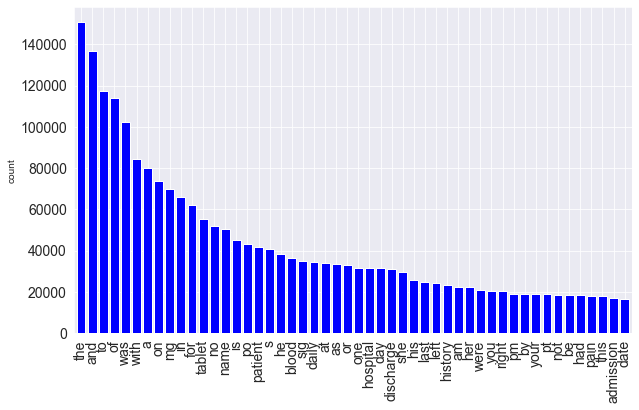

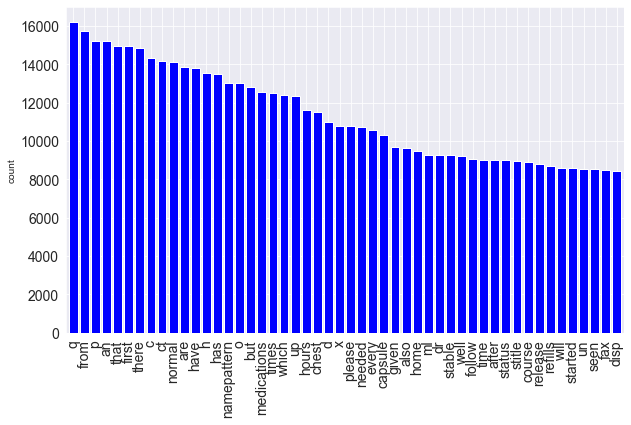

In [14]:
#Create the negative and positive matrices

neg_doc_matrix = vect.transform(df_train[df_train.READMITTED == 0].TEXT)
pos_doc_matrix = vect.transform(df_train[df_train.READMITTED == 1].TEXT)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

term_freq_df = pd.DataFrame([neg,pos],columns=vect.get_feature_names()).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

#Create a series from the sparse matrix
d = pd.Series(term_freq_df.total, 
              index = term_freq_df.index).sort_values(ascending=False)
ax = d[:50].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=90,color = 'b')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()
ax = d[50:100].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=90,color = 'b')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()

In [15]:
new_stop_words = ['the','and','to','of','was','with','a','on','mg', 'in','for','name',
                 'is','po', 'patient','s','he','blood', 'sig','daily','at','as','or',
                 'one','she','his','her','am','her', 'this', 'date'
                 'were','you','your','pt','pm','by','be','had','this','date', 'q',
                'from','there','an','that','p','c','ct','are','have','has','h','but','o',
                'namepattern','which','every','also','d','x', 'after','fax', 'and', 'are',
                 'further', 'if','it','of','their','those','where','which', 'while', 'who']


Let's test some models. We'll look at the ROC AUC scores as the performance metric

[<a href="#Data-Science-Capstone-Project">Jump back to Table of Contents</a>]  

## 4. Select an Algorithm  

  Name     Score
0   LR  0.600403
1   DT  0.548500
2   RF  0.612230
3  MNB  0.660130
4   AB  0.650057
5  XGB  0.687193
6  SVM  0.678143
Execution time 00:45:08


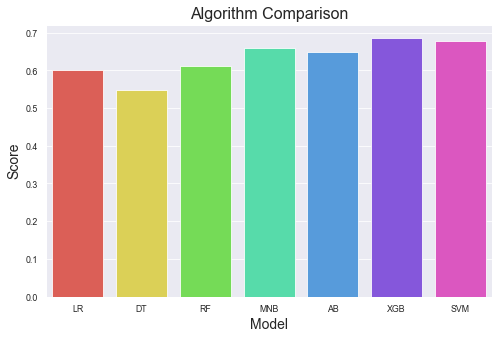

In [18]:
# ⏰ This cell may take a long time to run!
start = time.time()

models = []
models.append(('LR', LogisticRegression())) 
models.append(('DT', DecisionTreeClassifier())) 
models.append(('RF', RandomForestClassifier()))
models.append(('MNB', MultinomialNB()))
models.append(('AB', AdaBoostClassifier())) 
models.append(('XGB', XGBClassifier())) 
models.append(('SVM', SVC()))

# evaluate each model in turn
names = []
scores = []

for name, model in models:
    start= time.time()
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    score = cross_val_score(model, X_train_tf, y_train, cv=cv, scoring='roc_auc').round(decimals=4)   
    scores.append(score.mean())
    names.append(name)

cross_val = pd.DataFrame({'Name': names,'Score': scores})
print(cross_val)

#create plot
plt.figure(figsize=(8,5))
sns.set_context('paper')
sns.barplot(x = 'Name', y = 'Score',  data = cross_val,
            palette = 'hls',
            capsize = 0.5,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 'sd'   
            )
plt.title('Algorithm Comparison',fontsize=16)
plt.xlabel('Model',fontsize=14)
plt.ylabel('Score',fontsize=14)
plt.show;

exec_time()

[<a href="#Data-Science-Capstone-Project">Jump back to Table of Contents</a>]  

XGBoost has the highest AUC score. We will build a model using XGBoost algorithm.

# 5. Build the Model

In [21]:
#Let's create a list for storing the different model's performance
Model = []
AUC = []


### Check Performance of Validation Data

Accuracy: 69.05 %
Precision: 0.12136363636363637
Recall: 0.6095890410958904
F1-score: 0.20242608036391208
R2: -4.134470578099423
MSE: 0.30950279493968813
Prevalence: 0.32362459546925565
Specificity: 0.6960691823899371
---------------------------------------------------------------------

 Classification Report:
              precision    recall  f1-score   support

          NO       0.96      0.70      0.81      6360
         YES       0.12      0.61      0.20       438

    accuracy                           0.69      6798
   macro avg       0.54      0.65      0.51      6798
weighted avg       0.91      0.69      0.77      6798

---------------------------------------------------------------------
Confusion matrix:
 [[4427 1933]
 [ 171  267]]


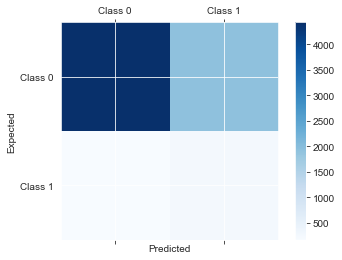

ROC AUC: 0.700


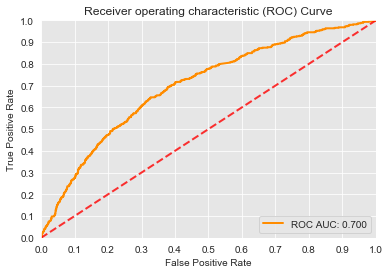

Execution time 00:02:00


In [32]:
# Let's test the model on the validation data. For details about the XGB parameter tuning, please see  Model_Tuning.ipnyb
# ⏰ This cell may take a long time to run!
start = time.time()
vect = CountVectorizer(lowercase = True, max_features = 4000, 
                       tokenizer = clean_tokenize, 
                       stop_words = new_stop_words)

# fit to learn the vocabulary
vect.fit(df_train.TEXT.values)

# Transform Notes into a vector format
X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)
X_test_tf = vect.transform(df_test.TEXT.values)

y_train = df_train.READMITTED
y_valid = df_valid.READMITTED
y_test = df_test.READMITTED

# define/fit model
XGB = XGBClassifier(learning_rate =0.1, n_estimators=150, max_depth=2, reg_lambda=1,
                    reg_alpha = 0.001, min_child_weight=3, gamma=0.0, subsample=0.85, 
                    colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, 
                    scale_pos_weight=1, seed=27).fit(X_train_tf, y_train)               

XGB_probs = XGB.predict_proba(X_valid_tf)[:, 1]              # predict probabilities for the positive outcome only
y_pred = XGB.predict(X_valid_tf)                                                        # predict

fpr_XGB, tpr_XGB, thresholds = roc_curve(y_valid, XGB_probs)                            # calculate roc_auc score
XGB_precision, XGB_recall, _ = precision_recall_curve(y_valid, XGB_probs)               # calculate pr_auc score 

auc = roc_auc_score(y_valid, XGB_probs) 
Model.append("XGBoost Validation")
AUC.append(auc)

#Summary report:
print_scores(y_valid, y_pred)
plot_roc_curve(y_valid, XGB_probs,  'XGB')  
   
exec_time()


### Check Performance of Test Data

Accuracy: 67.99 %
Precision: 0.11091626479614204
Recall: 0.6309226932668329
F1-score: 0.18866517524235646
R2: -4.766593364954036
MSE: 0.3200941453368638
Prevalence: 0.33553986466607827
Specificity: 0.6829763951852431
---------------------------------------------------------------------

 Classification Report:
              precision    recall  f1-score   support

          NO       0.97      0.68      0.80      6397
         YES       0.11      0.63      0.19       401

    accuracy                           0.68      6798
   macro avg       0.54      0.66      0.49      6798
weighted avg       0.92      0.68      0.76      6798

---------------------------------------------------------------------
Confusion matrix:
 [[4369 2028]
 [ 148  253]]


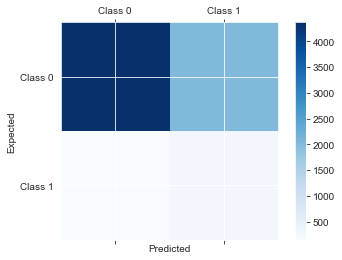

ROC AUC: 0.708


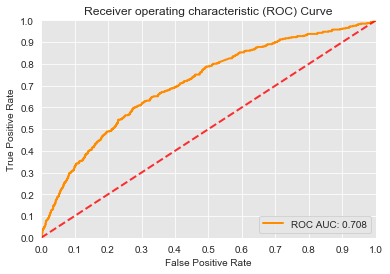

Execution time 00:02:02


In [33]:
# Now let's test the model on the test data. For details about the XGB parameter tuning, please see  Model_Tuning.ipnyb
start = time.time()

vect = CountVectorizer(lowercase = True, max_features = 4000, 
                       tokenizer = clean_tokenize, 
                       stop_words = new_stop_words)

# fit to learn the vocabulary
vect.fit(df_train.TEXT.values)

# Transform Notes into a vector format
X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)
X_test_tf = vect.transform(df_test.TEXT.values)

y_train = df_train.READMITTED
y_valid = df_valid.READMITTED
y_test = df_test.READMITTED

# define/fit model
XGB = XGBClassifier(learning_rate =0.1, n_estimators=150, max_depth=2, reg_lambda=1,
                    reg_alpha = 0.001, min_child_weight=3, gamma=0.0, subsample=0.85, 
                    colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, 
                    scale_pos_weight=1, seed=27).fit(X_train_tf, y_train)               

XGB_probs = XGB.predict_proba(X_test_tf)[:, 1]              # predict probabilities for the positive outcome only
y_pred = XGB.predict(X_test_tf)                                                        # predict

fpr_XGB, tpr_XGB, thresholds = roc_curve(y_test, XGB_probs)                            # calculate roc_auc score
XGB_precision, XGB_recall, _ = precision_recall_curve(y_test, XGB_probs)               # calculate pr_auc score 

auc = roc_auc_score(y_test, XGB_probs) 
Model.append("XGBoost Test")
AUC.append(auc)

#Summary report:
print_scores(y_test, y_pred)
plot_roc_curve(y_test, XGB_probs,  'XGB')  
   
exec_time()


[<a href="#Data-Science-Capstone-Project">Jump back to Table of Contents</a>]  

Train prevalence(n = 4248): 0.500
Valid prevalence(n = 6798): 0.064
Test prevalence(n = 6798): 0.059
Train AUC:0.837
Valid AUC:0.700
Test AUC:0.708
Train accuracy:0.751
Valid accuracy:0.690
Test accuracy:0.680
Train recall:0.691
Valid recall:0.610
Test recall:0.631
Train precision:0.785
Valid precision:0.121
Test precision:0.111
Train specificity:0.811
Valid specificity:0.696
Test specificity:0.683


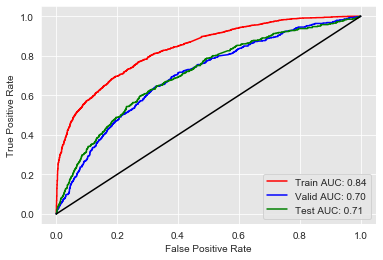

Execution time 00:02:05


In [34]:
#Let's fit the model to the test set and compare the model performance
## ⏰ This cell may take a long time to run!
start = time.time()

vect = CountVectorizer(lowercase = True, max_features = 4000, 
                       tokenizer = clean_tokenize, 
                       stop_words = new_stop_words)

# fit to learn the vocabulary
vect.fit(df_train.TEXT.values)

# Transform Notes into a vector format
X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)
X_test_tf = vect.transform(df_test.TEXT.values)

y_train = df_train.READMITTED
y_valid = df_valid.READMITTED
y_test = df_test.READMITTED

# define/fit model
XGB = XGBClassifier(learning_rate =0.1, n_estimators=150, max_depth=2, reg_lambda=1,
                    reg_alpha = 0.001, min_child_weight=3, gamma=0.0, subsample=0.85, 
                    colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, 
                    scale_pos_weight=1, seed=27).fit(X_train_tf, y_train)                           

XGB.fit(X_train_tf, y_train)

model = XGB
y_train_pred = model.predict_proba(X_train_tf)[:,1]
y_valid_pred = model.predict_proba(X_valid_tf)[:,1]
y_test_pred = model.predict_proba(X_test_tf)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_pred)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred)

thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_pred)
auc_valid = roc_auc_score(y_valid, y_valid_pred)
auc_test = roc_auc_score(y_test, y_test_pred)

print('Train prevalence(n = %d): %.3f'%(len(y_train),sum(y_train)/ len(y_train)))
print('Valid prevalence(n = %d): %.3f'%(len(y_valid),sum(y_valid)/ len(y_valid)))
print('Test prevalence(n = %d): %.3f'%(len(y_test),sum(y_test)/ len(y_test)))

print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)
print('Test AUC:%.3f'%auc_test)

print('Train accuracy:%.3f'%calc_accuracy(y_train, y_train_pred, thresh))
print('Valid accuracy:%.3f'%calc_accuracy(y_valid, y_valid_pred, thresh))
print('Test accuracy:%.3f'%calc_accuracy(y_test, y_test_pred, thresh))


print('Train recall:%.3f'%calc_recall(y_train, y_train_pred, thresh))
print('Valid recall:%.3f'%calc_recall(y_valid, y_valid_pred, thresh))
print('Test recall:%.3f'%calc_recall(y_test, y_test_pred, thresh))

print('Train precision:%.3f'%calc_precision(y_train, y_train_pred, thresh))
print('Valid precision:%.3f'%calc_precision(y_valid, y_valid_pred, thresh))
print('Test precision:%.3f'%calc_precision(y_test, y_test_pred, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train, y_train_pred, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_valid, y_valid_pred, thresh))
print('Test specificity:%.3f'%calc_specificity(y_test, y_test_pred, thresh))

plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot(fpr_test, tpr_test,'g-',label = 'Test AUC: %.2f'%auc_test)

plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

exec_time()


The training set results are really good, but the validation and test set results lag behind.  
We can plot the performance of the model on the validation dataset to get insight into how learning unfolded while training.


Accuracy: 69.05%


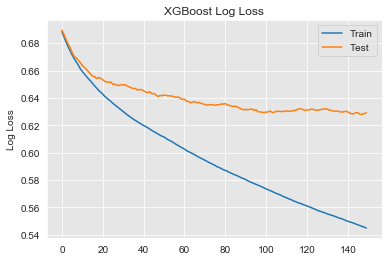

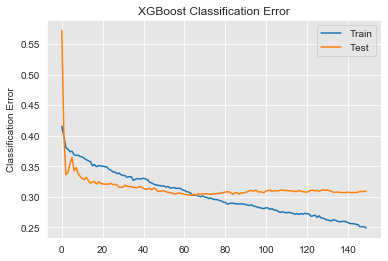

In [35]:
# Inspect the Learning Curve
eval_set = [(X_train_tf, y_train), (X_valid_tf, y_valid)]
model.fit(X_train_tf, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)
# make predictions for test data
predictions = model.predict(X_valid_tf)
# evaluate predictions
accuracy = accuracy_score(y_valid, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

results = model.evals_result()
epochs = len(results['validation_0']['error']) 
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train') 
ax.plot(x_axis, results['validation_1']['logloss'], label='Test') 
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()


# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train') 
ax.plot(x_axis, results['validation_1']['error'], label='Test') 
ax.legend()
plt.ylabel('Classification Error') 
plt.title('XGBoost Classification Error') 
plt.show()

In [36]:
# Early stopping rounds - indicate the number of iterations over which no improvement is observed. 

eval_set = [(X_valid_tf, y_valid)]
model.fit(X_train_tf, y_train, early_stopping_rounds=10, eval_metric="logloss",  eval_set=eval_set, verbose=True)
# make predictions for test data
predictions = model.predict(X_valid_tf)
# evaluate predictions
accuracy = accuracy_score(y_valid, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


[0]	validation_0-logloss:0.689395
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.686417
[2]	validation_0-logloss:0.682806
[3]	validation_0-logloss:0.679479
[4]	validation_0-logloss:0.676742
[5]	validation_0-logloss:0.673101
[6]	validation_0-logloss:0.67019
[7]	validation_0-logloss:0.669332
[8]	validation_0-logloss:0.667542
[9]	validation_0-logloss:0.665716
[10]	validation_0-logloss:0.663634
[11]	validation_0-logloss:0.662167
[12]	validation_0-logloss:0.660788
[13]	validation_0-logloss:0.659116
[14]	validation_0-logloss:0.657454
[15]	validation_0-logloss:0.655984
[16]	validation_0-logloss:0.655486
[17]	validation_0-logloss:0.654104
[18]	validation_0-logloss:0.65495
[19]	validation_0-logloss:0.654255
[20]	validation_0-logloss:0.653272
[21]	validation_0-logloss:0.652081
[22]	validation_0-logloss:0.651608
[23]	validation_0-logloss:0.65142
[24]	validation_0-logloss:0.65151
[25]	validation_0-logloss:0.649924
[26]	validation_0-logloss:0.649899
[

The model stopped training at epoch 103 and that the model with the best loss was observed at epoch 103. Log Loss is an important classification metric based on probabilities.  A lower log-loss value means better predictions.

In [37]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 15))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()


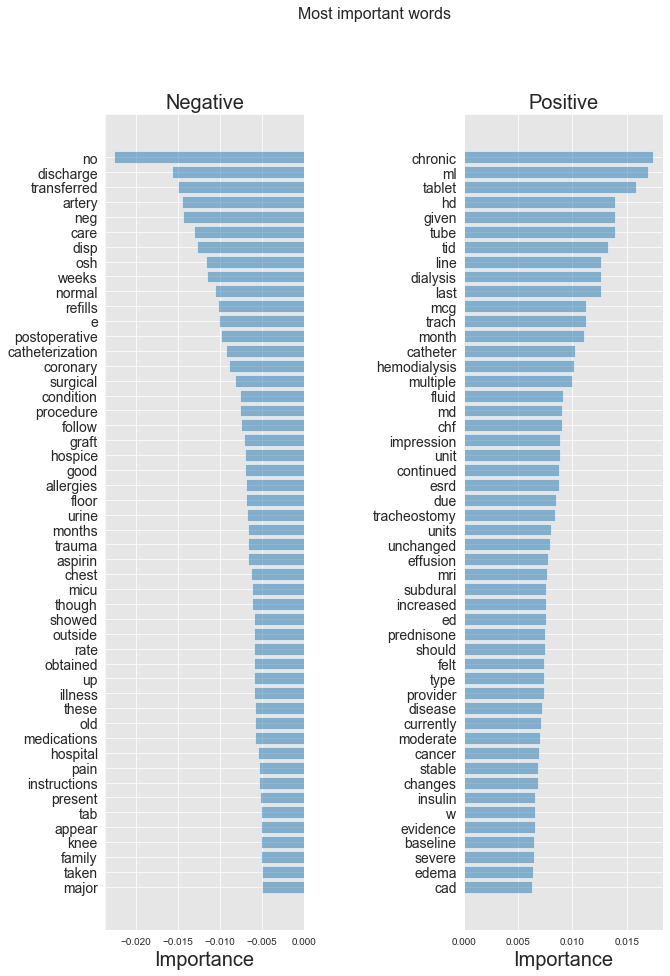

In [38]:
# logistic regression
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
clf.fit(X_train_tf, y_train)
y_train_preds = clf.predict_proba(X_train_tf)[:,1]
y_valid_preds = clf.predict_proba(X_valid_tf)[:,1]

importance = get_most_important_features(vect, clf, 50)
    
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words")

[<a href="#Data-Science-Capstone-Project">Jump back to Table of Contents</a>]  

## 6. Make Predictions

In [39]:
start = time.time()

XGB = XGBClassifier(learning_rate =0.1, n_estimators=150, max_depth=2, reg_lambda=1,
                    reg_alpha = 0.001, min_child_weight=3, gamma=0.0, subsample=0.85, 
                    colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, 
                    scale_pos_weight=1, seed=27).fit(X_train_tf, y_train)

model = XGB
y_train_pred = model.predict_proba(X_train_tf)[:,1]
y_valid_pred = model.predict_proba(X_valid_tf)[:,1]
y_test_pred = model.predict_proba(X_test_tf)[:,1]

print(y_train[:10].values)
print(y_train_pred[:10])
   
exec_time()


[1 0 0 0 1 0 0 0 0 1]
[0.5588428  0.4663568  0.46363688 0.29838517 0.722627   0.28920397
 0.4187936  0.25278938 0.23664422 0.73728424]
Execution time 00:00:04


In [42]:
#Test Prediction

review= df_valid.TEXT.iloc[25]
print(XGB.predict(vect.transform([review]))[0])
print(df_valid.READMITTED.iloc[25])

0
0


[<a href="#Data-Science-Capstone-Project">Jump back to Table of Contents</a>]  

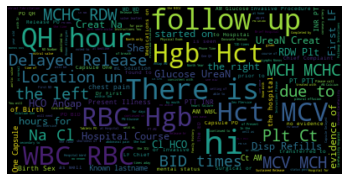

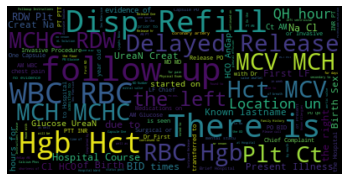

In [43]:
#. Word Cloud for the positive & negative outcomes

text = df_train_pos.TEXT.str.cat(sep=', ')

text = text.replace("\n", "")
text = text.replace('\r', '')
text = ''.join([i for i in text if not i.isdigit()])
new_stopwords = ['patient','was','day','mg','daily', 'the' 'last','name','have','has', 'been','did', 'however','after', 'but', 'from',
                'he', 'and', 'was', 'were','date', 'from','which','every','also','namepattern','telephone','fax','admission'
                ,'discharge','addendum','disposition', 'Past Medical History','Telephone/Fax','Provider',
                 'history of','Tablet PO', 'Job Number', 'as needed','tablet','blood','sig','STitle','Tre','last','pattern']
stop_words = stopwords.words('english')
remove = '|'.join(new_stopwords)
    
regex = re.compile(r'\b('+remove+r')\b', flags=re.IGNORECASE)
out = regex.sub("", text)
out.translate(str.maketrans('', '', string.punctuation))

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(out)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show();

text = df_train_neg.TEXT.str.cat(sep=', ')

text = text.replace("\n", "")
text = text.replace('\r', '')
text = ''.join([i for i in text if not i.isdigit()])
new_stopwords = ['patient','was','day','mg','daily', 'the' 'last','name','have','has', 'been','did', 'however','after', 'but', 'from',
                'he', 'and', 'was', 'were','date', 'from','which','every','also','namepattern','telephone','fax','admission'
                ,'discharge','addendum','disposition', 'Past Medical History','Telephone/Fax','Provider',
                 'history of','Tablet PO', 'Job Number', 'as needed','tablet','blood','sig','STitle','Tre','last','pattern']
stop_words = stopwords.words('english')
remove = '|'.join(new_stopwords)
    
regex = re.compile(r'\b('+remove+r')\b', flags=re.IGNORECASE)
out = regex.sub("", text)
out.translate(str.maketrans('', '', string.punctuation))

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(out)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Train AUC:0.838
Valid AUC:0.703
Train accuracy:0.753
Valid accuracy:0.685
Train recall:0.696
Valid recall:0.605
Train precision:0.785
Valid precision:0.119
Train specificity:0.810
Valid specificity:0.691
Train prevalence:0.500
Valid prevalence:0.064


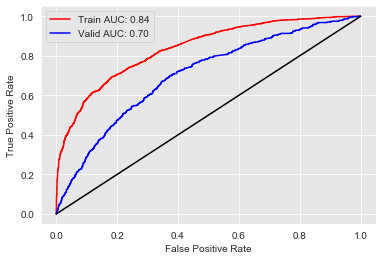

Execution time 00:02:16


In [44]:

#Test model with Bi-gram ngram_range

start = time.time()

vect = CountVectorizer(max_features = 4000, 
                       tokenizer = clean_tokenize, 
                       stop_words = new_stop_words, ngram_range=(1, 2))
vect.fit(df_train.TEXT.values)

X_train_tf_bi = vect.transform(df_train.TEXT.values)
X_valid_tf_bi = vect.transform(df_valid.TEXT.values)
X_test_tf_bi = vect.transform(df_test.TEXT.values)

y_train_bi = df_train.READMITTED
y_valid_bi = df_valid.READMITTED
y_test_bi = df_test.READMITTED

# define/fit model
XGB = XGBClassifier(learning_rate =0.1, n_estimators=150, max_depth=2, reg_lambda=1,
                    reg_alpha = 0.001, min_child_weight=3, gamma=0.0, subsample=0.85, 
                    colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, 
                    scale_pos_weight=1, seed=27).fit(X_train_tf_bi, y_train_bi)     

model = XGB
y_train_bi_pred = model.predict_proba(X_train_tf_bi)[:,1]
y_valid_bi_pred = model.predict_proba(X_valid_tf_bi)[:,1]
y_test_bi_pred = model.predict_proba(X_test_tf_bi)[:,1]


fpr_train, tpr_train, thresholds_train = roc_curve(y_train_bi, y_train_bi_pred)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid_bi, y_valid_bi_pred)


thresh = 0.5

auc_train = roc_auc_score(y_train_bi, y_train_bi_pred)
auc_valid = roc_auc_score(y_valid_bi, y_valid_bi_pred)

print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)

print('Train accuracy:%.3f'%calc_accuracy(y_train_bi, y_train_bi_pred, thresh))
print('Valid accuracy:%.3f'%calc_accuracy(y_valid_bi, y_valid_bi_pred, thresh))


print('Train recall:%.3f'%calc_recall(y_train_bi, y_train_bi_pred, thresh))
print('Valid recall:%.3f'%calc_recall(y_valid_bi, y_valid_bi_pred, thresh))

print('Train precision:%.3f'%calc_precision(y_train_bi, y_train_bi_pred, thresh))
print('Valid precision:%.3f'%calc_precision(y_valid_bi, y_valid_bi_pred, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train_bi, y_train_bi_pred, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_valid_bi, y_valid_bi_pred, thresh))

print('Train prevalence:%.3f'%calc_prevalence(y_train_bi))
print('Valid prevalence:%.3f'%calc_prevalence(y_valid_bi))


plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show();

auc = roc_auc_score(y_valid_bi, y_valid_bi_pred) 
Model.append("XGBoost w/ bi-gram")
AUC.append(auc)
    
exec_time()


[<a href="#Data-Science-Capstone-Project">Jump back to Table of Contents</a>]  

Train AUC:0.836
Valid AUC:0.697
Train accuracy:0.757
Valid accuracy:0.688
Train recall:0.697
Valid recall:0.596
Train precision:0.792
Valid precision:0.118
Train specificity:0.816
Valid specificity:0.694
Train prevalence:0.500
Valid prevalence:0.064


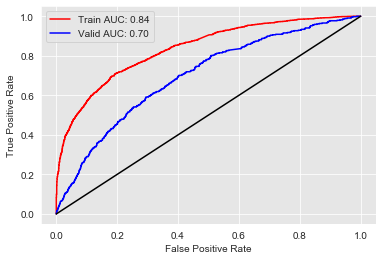

Execution time 00:02:42


In [45]:

#Try model with tri-gram ngram range

start = time.time()

vect = CountVectorizer(max_features = 4000, 
                       tokenizer = clean_tokenize, 
                       stop_words = new_stop_words, ngram_range=(1, 3))
vect.fit(df_train.TEXT.values)

X_train_tf_tri = vect.transform(df_train.TEXT.values)
X_valid_tf_tri = vect.transform(df_valid.TEXT.values)
X_test_tf_tri = vect.transform(df_test.TEXT.values)

y_train_tri = df_train.READMITTED
y_valid_tri = df_valid.READMITTED
y_test_tri = df_test.READMITTED

# define/fit model
XGB = XGBClassifier(learning_rate =0.1, n_estimators=150, max_depth=2, reg_lambda=1,
                    reg_alpha = 0.001, min_child_weight=3, gamma=0.0, subsample=0.85, 
                    colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, 
                    scale_pos_weight=1, seed=27).fit(X_train_tf_tri, y_train_tri)     


model = XGB
y_train_tri_pred = model.predict_proba(X_train_tf_tri)[:,1]
y_valid_tri_pred = model.predict_proba(X_valid_tf_tri)[:,1]
y_test_tri_pred = model.predict_proba(X_test_tf_tri)[:,1]


fpr_train, tpr_train, thresholds_train = roc_curve(y_train_tri, y_train_tri_pred)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid_tri, y_valid_tri_pred)


thresh = 0.5

auc_train = roc_auc_score(y_train_tri, y_train_tri_pred)
auc_valid = roc_auc_score(y_valid_tri, y_valid_tri_pred)

print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)

print('Train accuracy:%.3f'%calc_accuracy(y_train_tri, y_train_tri_pred, thresh))
print('Valid accuracy:%.3f'%calc_accuracy(y_valid_tri, y_valid_tri_pred, thresh))


print('Train recall:%.3f'%calc_recall(y_train_tri, y_train_tri_pred, thresh))
print('Valid recall:%.3f'%calc_recall(y_valid_tri, y_valid_tri_pred, thresh))

print('Train precision:%.3f'%calc_precision(y_train_tri, y_train_tri_pred, thresh))
print('Valid precision:%.3f'%calc_precision(y_valid_tri, y_valid_tri_pred, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train_tri, y_train_tri_pred, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_valid_tri, y_valid_tri_pred, thresh))

print('Train prevalence:%.3f'%calc_prevalence(y_train_tri))
print('Valid prevalence:%.3f'%calc_prevalence(y_valid_tri))


plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show();

auc = roc_auc_score(y_valid_tri, y_valid_tri_pred) 
Model.append("XGBoost w/ tri-gram")
AUC.append(auc)
    
exec_time()


[<a href="#Data-Science-Capstone-Project">Jump back to Table of Contents</a>]  

Train AUC:0.863
Valid AUC:0.681
Train accuracy:0.773
Valid accuracy:0.667
Train recall:0.736
Valid recall:0.603
Train precision:0.795
Valid precision:0.112
Train specificity:0.810
Valid specificity:0.671
Train prevalence:0.500
Valid prevalence:0.064


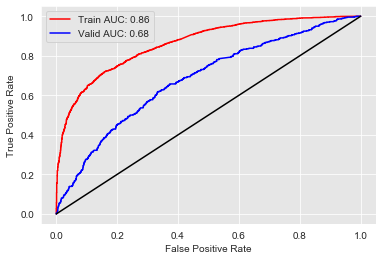

Execution time 00:02:43


In [46]:

#calculate word frequencies via TF-IDF Term Frequency - Inverse Document Frequency 

start = time.time()

vect = TfidfVectorizer(max_features = 4000, 
                       tokenizer = clean_tokenize, 
                       stop_words = new_stop_words, ngram_range=(1, 3))
vect.fit(df_train.TEXT.values)

X_train_tf_tfidf = vect.transform(df_train.TEXT.values)
X_valid_tf_tfidf = vect.transform(df_valid.TEXT.values)
X_test_tf_tfidf = vect.transform(df_test.TEXT.values)

y_train_tfidf = df_train.READMITTED
y_valid_tfidf = df_valid.READMITTED
y_test_tfidf = df_test.READMITTED

# define/fit model
XGB = XGBClassifier(learning_rate =0.1, n_estimators=150, max_depth=2, reg_lambda=1,
                    reg_alpha = 0.001, min_child_weight=3, gamma=0.0, subsample=0.85, 
                    colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, 
                    scale_pos_weight=1, seed=27).fit(X_train_tf_tfidf, y_train_tfidf)    

model = XGB
y_train_tfidf_pred = model.predict_proba(X_train_tf_tfidf)[:,1]
y_valid_tfidf_pred = model.predict_proba(X_valid_tf_tfidf)[:,1]
y_test_tfidf_pred = model.predict_proba(X_test_tf_tfidf)[:,1]


fpr_train, tpr_train, thresholds_train = roc_curve(y_train_tfidf, y_train_tfidf_pred)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid_tfidf, y_valid_tfidf_pred)

thresh = 0.5

auc_train = roc_auc_score(y_train_tfidf, y_train_tfidf_pred)
auc_valid = roc_auc_score(y_valid_tfidf, y_valid_tfidf_pred)

print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)

print('Train accuracy:%.3f'%calc_accuracy(y_train_tfidf, y_train_tfidf_pred, thresh))
print('Valid accuracy:%.3f'%calc_accuracy(y_valid_tfidf, y_valid_tfidf_pred, thresh))


print('Train recall:%.3f'%calc_recall(y_train_tfidf, y_train_tfidf_pred, thresh))
print('Valid recall:%.3f'%calc_recall(y_valid_tfidf, y_valid_tfidf_pred, thresh))

print('Train precision:%.3f'%calc_precision(y_train_tfidf, y_train_tfidf_pred, thresh))
print('Valid precision:%.3f'%calc_precision(y_valid_tfidf, y_valid_tfidf_pred, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train_tfidf, y_train_tfidf_pred, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_valid_tfidf, y_valid_tfidf_pred, thresh))

print('Train prevalence:%.3f'%calc_prevalence(y_train_tfidf))
print('Valid prevalence:%.3f'%calc_prevalence(y_valid_tfidf))


plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show();

auc = roc_auc_score(y_valid_tfidf, y_valid_tfidf_pred) 
Model.append("XGBoost w/ TF-IDF tri-gram")
AUC.append(auc)
    
exec_time()


[<a href="#Data-Science-Capstone-Project">Jump back to Table of Contents</a>]  

## Neural Networks

In [47]:

y_train_binary = to_categorical(y_train)
y_valid_binary = to_categorical(y_valid)
X_train_Array = X_train_tf.todense()
X_valid_Array = X_valid_tf.todense()

# Initialize a sequential model
model = Sequential()

# Two layers with relu activation
model.add(Dense(500, input_dim = X_train_tf.shape[1] , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1000, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(500, activation = 'relu'))

# One layer with softmax activation 
model.add(Dense(2, activation = 'softmax'))

# Compile the model
model.compile(optimizer='SGD', loss= 'categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_Array, y_train_binary, epochs=120, batch_size=256, validation_data=(X_valid_Array, y_valid_binary))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 4248 samples, validate on 6798 samples
Epoch 1/120
4248/4248 [==============================] - 1s 218us/step - loss: 0.8412 - accuracy: 0.5052 - val_loss: 0.7902 - val_accuracy: 0.3951
Epoch 2/120
4248/4248 [==============================] - 1s 178us/step - loss: 0.7810 - accuracy: 0.5285 - val_loss: 0.7688 - val_accuracy: 0.4440
Epoch 3/120
4248/4248 [==============================] - 1s 172us/step - loss: 0.7307 - accuracy: 0.5480 - val_loss: 0.7573 - val_accuracy: 0.4610
Epoch 4/120
4248/4248 [==============================] - 1s 171us/step - loss: 0.7092 - accuracy: 0.5556 - val_loss: 0.6764 - val_accuracy: 0.6367
Epoch 5/120
4248/4248 [==============================] - 1s 178us/step - loss: 0.7148 - accuracy: 0.5598 - val_loss: 0.7814 - val_accuracy: 0.4440
Epoch 6/120
4248/4248 [==============================] - 1s 180us/step - loss: 0.6967 - accuracy:

Epoch 52/120
4248/4248 [==============================] - 1s 173us/step - loss: 0.5756 - accuracy: 0.7015 - val_loss: 0.7040 - val_accuracy: 0.6370
Epoch 53/120
4248/4248 [==============================] - 1s 174us/step - loss: 0.5711 - accuracy: 0.6987 - val_loss: 0.6634 - val_accuracy: 0.6731
Epoch 54/120
4248/4248 [==============================] - 1s 180us/step - loss: 0.5676 - accuracy: 0.7072 - val_loss: 0.6988 - val_accuracy: 0.6425
Epoch 55/120
4248/4248 [==============================] - 1s 183us/step - loss: 0.5666 - accuracy: 0.6989 - val_loss: 0.6729 - val_accuracy: 0.6645
Epoch 56/120
4248/4248 [==============================] - 1s 187us/step - loss: 0.5549 - accuracy: 0.7173 - val_loss: 0.6747 - val_accuracy: 0.6620
Epoch 57/120
4248/4248 [==============================] - 1s 187us/step - loss: 0.5623 - accuracy: 0.7015 - val_loss: 0.6226 - val_accuracy: 0.7039
Epoch 58/120
4248/4248 [==============================] - 1s 181us/step - loss: 0.5555 - accuracy: 0.7152 - val_

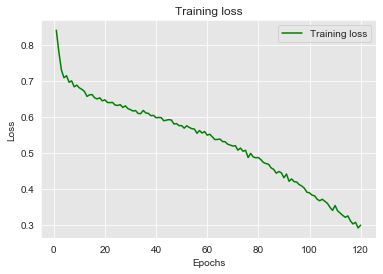

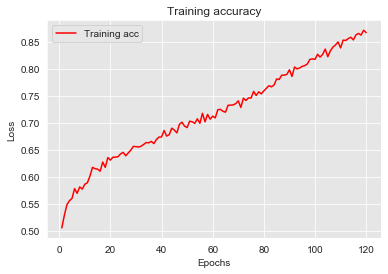

In [48]:
history_dict = history.history
history_dict.keys()

#Plot the results

history_dict = history.history
loss_values = history_dict['loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training accuracy vs the number of epochs
acc_values = history_dict['accuracy'] 

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

It seems like we could just keep on going and accuracy would go up. 

In [49]:
#Make Predictions
y_pred = model.predict_proba(X_valid_Array)
fpr, tpr, _ = metrics.roc_curve(np.array(y_valid), y_pred[:,1])
auc = metrics.auc(fpr,tpr)
Model.append("Neural Network")
AUC.append(auc)

In [50]:
#Evaluate Performance

# Output (probability) predictions for the test set 
y_hat_test = model.predict(X_valid_Array) 

# Print the loss and accuracy for the training set 
results_train = model.evaluate(X_train_Array, y_train_binary)
results_train

# Print the loss and accuracy for the test set 
results_test = model.evaluate(X_valid_Array, y_valid_binary)
results_test



6798/6798 [==============================] - 1s 81us/step


[0.926023857738734, 0.6140041351318359]

[<a href="#Data-Science-Capstone-Project">Jump back to Table of Contents</a>]  

## Model Performance

In [51]:
#Let's Compare the Model's performance
model_performance = pd.DataFrame({'Model': Model, 'AUC': AUC})
model_performance



,Model,AUC
0,XGBoost,0.699737
1,XGBoost Validation,0.699737
2,XGBoost Test,0.708171
3,XGBoost w/ bi-gram,0.702579
4,XGBoost w/ tri-gram,0.697062
5,XGBoost w/ TF-IDF tri-gram,0.680659
6,Neural Network,0.669079


[<a href="#Data-Science-Capstone-Project">Jump back to Table of Contents</a>]  

## Interpretation

+ XGBoost Classifier was selected as the best model to predict readmissions from discharge notes.  
+ BoW with XGB model yields slightly better result than TF-IDF and the complex Neural Network model.
+ Increasing n-gram range did not improve scores for BoW method.
+ Train data overfitting - early stop and tuning the regularization parameter


## Future Work

XGBoost Classifier was selected as the most accurate model to predict readmissions from discharge notes.  
+ Compared to random predictions, results from our predictive model (AUC=.71) is a good baseline for further improving our model. 
+ Feature engineering, ensemble of models and parameter tuning of the model will help the adoption of the model as a clinical decision system for evaluating readmission
+ Explore other unstructured notes and/or combine with structured clinical information to strengthen predictive scores. 

Predicting hospital readmissions based on unstructured data opens many opportunities in predictive analytics where a vast amount of untapped data could be utilized to reduce hospital readmissions, improve outcomes for the patients, lower healthcare cost while providing quality care.

Thank you for a wonderful data science learning experience!!